In [15]:
from numpy import *
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import simple_norm
from astropy.modeling import models
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy import units as u
import astropy
import photutils
import time
from astropy.stats import sigma_clipped_stats
import statmorph
from statmorph.utils.image_diagnostics import make_figure
import glob
from PIL import Image
import os
import pandas as pd
import numpy as np
import pyregion
from regions import Regions
from math import *
from numpy import inf
# plt.style.use("stylesheet.txt")
import sep
import scipy
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore')

In [16]:
xmm_30_path = "/Users/arames52/Desktop/Primary Project/Multiwavelength_bcg/ALMA/ND/XMM-30_ALMA.fits"

In [17]:
bcg_images_path = sorted(glob.glob("ALMA/*.fits"))
%store -r rms_dict

In [18]:
def morphology_computation(data):
    threshold = photutils.detect_threshold(data, 1.8, background = 0)
    npixels = 5 
    segm = photutils.detect_sources(data, threshold, npixels)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    source_morphs = statmorph.source_morphology(data, segmap, gain = 1)
    morph = source_morphs[0]
    return morph, segmap

In [19]:
def image_cutouts(bcg):
    hdu = fits.open(bcg)[0]
    image = hdu.data[0,0,:,:]
    image = np.nan_to_num(image)
    image /= np.amax(image)
    header = hdu.header
    ra = header['CRVAL1']
    dec = header['CRVAL2']
    wcs = WCS(header, naxis = 2)
    position = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    s = u.Quantity((8,8), u.arcsec)
    cutout = Cutout2D(image, position = position, size = s, wcs = wcs)
    return cutout, wcs

In [29]:
offsets = {}
alma_centroid = {}

In [30]:
# fig, axs = plt.subplots(5,4, figsize=(12,10), facecolor='w', edgecolor='k')
# axs = axs.ravel()
for bcg, i in zip(bcg_images_path, range(len(bcg_images_path))):
    name = bcg.split("_ALMA.fits")[0].split("ALMA/")[1]
    data,wcs = image_cutouts(bcg)
    image = data.data
    morph,segmap = morphology_computation(image)
    original_center = wcs.pixel_to_world(data.center_cutout[0], data.center_cutout[1])
    alma_center = wcs.pixel_to_world(morph.xc_centroid, morph.yc_centroid)
    alma_centroid[name] = alma_center
#     axs[i].imshow(image, origin = 'lower', 
#                  norm = ImageNormalize(image, interval = ZScaleInterval(), stretch = LinearStretch()),
#                 cmap = 'Greys_r')
#     axs[i].scatter(morph.xc_centroid, morph.yc_centroid, color = 'red', marker = '+', label = 'alma centroid', linewidth = 1)
#     axs[i].scatter(data.center_cutout[0], data.center_cutout[1], color = 'blue', marker = '+', label = '3.6micron centre', linewidth = 1)
# #     axs[i].set_title("Original Image")
# #     axs[1].imshow(segmap, origin = 'lower', cmap = 'Greys_r')
# #     axs[1].set_title("CAS Segmap")
# #     fig.legend(loc = 'center')
#     axs[i].axes.xaxis.set_visible(False)
#     axs[i].axes.yaxis.set_visible(False)
#     axs[i].set_aspect('equal')
#     axs[i].set_title(name + " " + str(round(original_center.separation(alma_center).arcsecond, 3)) + "'' offset")
#     handles, labels = axs[i].get_legend_handles_labels()
#     offsets[name] = round(original_center.separation(alma_center).arcsecond, 3)
# fig.legend(handles, labels, bbox_to_anchor=(0.95,0.15))
# axs[19].set_axis_off()
# # fig.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# fig.savefig("bcgs_offset.jpg", dpi = 300)
#     axs[1].axes.xaxis.set_visible(False)
#     axs[1].axes.yaxis.set_visible(False)
#     fig.suptitle(name + " " + str(original_center.separation(alma_center).arcsecond) + "'' offset", y = 0.75)
#     fig.savefig(name + "_offset.jpg", dpi = 300)
#     print(name)
#     print(original_center.separation(alma_center).arcsecond)
#     print("--------------")

In [31]:
data,wcs = image_cutouts(xmm_30_path)
image = data.data
morph,segmap = morphology_computation(image)
original_center = wcs.pixel_to_world(data.center_cutout[0], data.center_cutout[1])
alma_center = wcs.pixel_to_world(morph.xc_centroid, morph.yc_centroid)

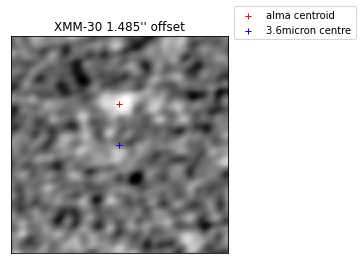

In [32]:
name = 'XMM-30'
fig,axs = plt.subplots(1,1, figsize = (4,4))
axs.imshow(image, origin = 'lower', 
                 norm = ImageNormalize(image, interval = ZScaleInterval(), stretch = LinearStretch()),
                cmap = 'Greys_r')
axs.scatter(morph.xc_centroid, morph.yc_centroid, color = 'red', marker = '+', label = 'alma centroid', linewidth = 1)
axs.scatter(data.center_cutout[0], data.center_cutout[1], color = 'blue', marker = '+', label = '3.6micron centre', linewidth = 1)
axs.axes.xaxis.set_visible(False)
axs.axes.yaxis.set_visible(False)
alma_centroid[name] = wcs.pixel_to_world(morph.xc_centroid, morph.yc_centroid)
axs.set_title(name + " " + str(round(original_center.separation(alma_center).arcsecond, 3)) + "'' offset")
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.35,1))
# fig.savefig("xmm30_offset.jpg", dpi = 300,bbox_inches="tight")
offsets[name] = round(original_center.separation(alma_center).arcsecond, 3)

In [33]:
alma_centroid

{'CDFS-18': <SkyCoord (ICRS): (ra, dec) in deg
     (53.32441549, -26.90039044)>,
 'CDFS-19': <SkyCoord (ICRS): (ra, dec) in deg
     (53.48867103, -27.26361894)>,
 'ES1-18': <SkyCoord (ICRS): (ra, dec) in deg
     (7.03682225, -43.34920686)>,
 'ES1-34': <SkyCoord (ICRS): (ra, dec) in deg
     (9.21625725, -42.12216359)>,
 'ES1_z_0.88': <SkyCoord (ICRS): (ra, dec) in deg
     (8.82606033, -42.69018176)>,
 'ES1_z_0.99': <SkyCoord (ICRS): (ra, dec) in deg
     (9.42583024, -43.65742667)>,
 'ES1_z_0.99b': <SkyCoord (ICRS): (ra, dec) in deg
     (8.68682931, -42.46247959)>,
 'ES1_z_1.04': <SkyCoord (ICRS): (ra, dec) in deg
     (8.86268023, -42.24453977)>,
 'ES1_z_1.38': <SkyCoord (ICRS): (ra, dec) in deg
     (8.64654544, -42.49755029)>,
 'ES1_z_1.40': <SkyCoord (ICRS): (ra, dec) in deg
     (8.30454461, -43.50318306)>,
 'ES1_z_1.60': <SkyCoord (ICRS): (ra, dec) in deg
     (9.49796194, -42.98861287)>,
 'ES1_z_1.65': <SkyCoord (ICRS): (ra, dec) in deg
     (7.97532123, -44.44367109)>,
 'E

In [34]:
%store alma_centroid

Stored 'alma_centroid' (dict)
